In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#spotify WebAPI
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import os
%matplotlib inline
import spotipy.util as util

!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 79 kB 8.9 MB/s 
     |████████████████████████████████| 4.0 MB 40.4 MB/s 
     |████████████████████████████████| 1.2 MB 56.5 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 6.6 MB 38.1 MB/s 
     |████████████████████████████████| 880 kB 66.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120748 sha256=8b852e8273bb0a2a87f59a608ed40d91b4545dc7c8261cc555ce14fb6b009faa
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895253 sha256=d2cc0e94502003129a220f0dcb577eaf64d45b3079342365fc5d2d1b3911c6db
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
S

## Spotipy (Python Library for Spotify Web API)

1. Extracting albums from artists

In [ ]:
#souce citation: https://spotipy.readthedocs.io/en/2.19.0/

os.environ["SPOTIPY_CLIENT_ID"] ='f236bc4680a64fb8abceca08c84c094e'
os.environ["SPOTIPY_CLIENT_SECRET"] ='77dc434af00c4a52a1fa6050fef86ee3'

#artist: Coldplay
birdy_uri = 'https://open.spotify.com/artist/4gzpq5DPGxSnKTe4SA8HAU?si=TOG_Sl78SqS6cUC-vr5rgA'
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

results = spotify.artist_albums(birdy_uri, album_type='album')
albums = results['items']
while results['next']:
    results = spotify.next(results)
    albums.extend(results['items'])

for album in albums:
    print(album['name'])

Music Of The Spheres
Everyday Life
Everyday Life
Everyday Life
Everyday Life
Live in Buenos Aires
Love in Tokyo
A Head Full of Dreams
A Head Full of Dreams Tour Edition
Ghost Stories Live 2014
Ghost Stories
Live 2012
Mylo Xyloto
Mylo Xyloto
Mylo Xyloto
LeftRightLeftRightLeft (Live)
Viva La Vida (Prospekt's March Edition)
Viva La Vida (Prospekt's March Edition)
Viva La Vida (Prospekt's March Edition)
Viva La Vida (Prospekt's March Edition)
Viva La Vida (Prospekt's March Edition)
Viva La Vida or Death and All His Friends
Viva La Vida or Death and All His Friends
Viva La Vida or Death and All His Friends
Viva La Vida or Death and All His Friends
Viva La Vida or Death and All His Friends
X&Y
Live 2003
A Rush of Blood to the Head
Parachutes


2. Extracting tracks from playlists

In [ ]:
#source citation: https://towardsdatascience.com/extracting-song-data-from-the-spotify-api-using-python-b1e79388d50

cid ='f236bc4680a64fb8abceca08c84c094e'
secret ='77dc434af00c4a52a1fa6050fef86ee3'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

#playlist: Top 50 - USA
playlist_link = "https://open.spotify.com/playlist/37i9dQZEVXbLRQDuF5jeBp?si=9013d4d6311d48b0"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

Extract the name of each track, the name of the album that it belongs to, and the popularity of the track (we expect this to be high since we’re looking at the top 50 most popular songs in the USA). 

In [ ]:
track_uri_s = []
for track in sp.playlist_tracks(playlist_URI)["items"]:
    #URI
    track_uri = track["track"]["uri"]
    track_uri_s.append(track_uri)
    
    #Track name
    track_name = track["track"]["name"]
    
    #Main Artist
    artist_uri = track["track"]["artists"][0]["uri"]
    artist_info = sp.artist(artist_uri)
    
    #Name, popularity, genre
    artist_name = track["track"]["artists"][0]["name"]
    artist_pop = artist_info["popularity"]
    artist_genres = artist_info["genres"]
    
    #Album
    album = track["track"]["album"]["name"]
    
    #Popularity of the track
    track_pop = track["track"]["popularity"]

In [ ]:
#audio features of first track in playlist
sp.audio_features(track_uri_s)[0]

{'danceability': 0.52,
 'energy': 0.731,
 'key': 6,
 'loudness': -5.338,
 'mode': 0,
 'speechiness': 0.0557,
 'acousticness': 0.342,
 'instrumentalness': 0.00101,
 'liveness': 0.311,
 'valence': 0.662,
 'tempo': 173.93,
 'type': 'audio_features',
 'id': '4LRPiXqCikLlN15c3yImP7',
 'uri': 'spotify:track:4LRPiXqCikLlN15c3yImP7',
 'track_href': 'https://api.spotify.com/v1/tracks/4LRPiXqCikLlN15c3yImP7',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4LRPiXqCikLlN15c3yImP7',
 'duration_ms': 167303,
 'time_signature': 4}

3. Convert Spotipy playlist data to dataframe

In [ ]:
#features for all songs in playlist
audio_features = []
for i in range(len(track_uris)):
    audio_features.append(sp.audio_features(track_uris[i]))
audio_features[0]

#track names
track_names = []
for k in sp.playlist_tracks(playlist_URI)["items"]:
    track_names.append(k["track"]["name"])
track_names

['As It Was',
 'First Class',
 'WAIT FOR U (feat. Drake & Tems)',
 'PUFFIN ON ZOOTIEZ',
 'Heat Waves',
 "I'M ON ONE (feat. Drake)",
 'About Damn Time',
 '712PM',
 "I'M DAT N****",
 'INDUSTRY BABY (feat. Jack Harlow)',
 'No Role Modelz',
 'STAY (with Justin Bieber)',
 'KEEP IT BURNIN (feat. Kanye West)',
 'good 4 u',
 'Woman',
 'Wait a Minute!',
 'Ghost',
 'Enemy (with JID) - from the series Arcane League of Legends',
 '505',
 'Thousand Miles',
 'LOVE YOU BETTER',
 'Honest (feat. Don Toliver)',
 'MASSAGING ME',
 'PROVENZA',
 'Dark Red',
 'Need to Know',
 'Super Gremlin',
 'Knife Talk (with 21 Savage ft. Project Pat)',
 'I Love You So',
 "Don't Think Jesus",
 'Sweater Weather',
 'MAMIII',
 'FOR A NUT (feat. Gunna & Young Thug)',
 'Bam Bam (feat. Ed Sheeran)',
 'GOLD STACKS',
 'THATS WHAT I WANT',
 'Something in the Orange',
 'See You Again (feat. Kali Uchis)',
 'Wasted On You',
 'Nail Tech',
 'Cold Heart - PNAU Remix',
 'Boyfriend',
 'traitor',
 "We Don't Talk About Bruno",
 'Shivers',
 

In [ ]:
#construct dataframe for audio_features
dfs = []

for x in audio_features:
    df = pd.DataFrame(x)
    dfs.append(df)

final_df = pd.concat(dfs, ignore_index=True)
final_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.520,0.731,6,-5.338,0,0.0557,0.342000,0.001010,0.3110,0.6620,173.930,audio_features,4LRPiXqCikLlN15c3yImP7,spotify:track:4LRPiXqCikLlN15c3yImP7,https://api.spotify.com/v1/tracks/4LRPiXqCikLl...,https://api.spotify.com/v1/audio-analysis/4LRP...,167303,4
1,0.905,0.563,8,-6.135,1,0.1020,0.025400,0.000010,0.1130,0.3240,106.998,audio_features,1rDQ4oMwGJI7B4tovsBOxc,spotify:track:1rDQ4oMwGJI7B4tovsBOxc,https://api.spotify.com/v1/tracks/1rDQ4oMwGJI7...,https://api.spotify.com/v1/audio-analysis/1rDQ...,173948,4
2,0.463,0.642,1,-4.474,1,0.3400,0.314000,0.000000,0.0686,0.3390,83.389,audio_features,59nOXPmaKlBfGMDeOVGrIK,spotify:track:59nOXPmaKlBfGMDeOVGrIK,https://api.spotify.com/v1/tracks/59nOXPmaKlBf...,https://api.spotify.com/v1/audio-analysis/59nO...,189893,4
3,0.883,0.657,8,-5.748,1,0.3050,0.060300,0.000000,0.1280,0.2840,124.992,audio_features,1qMMYpVatbRITKCfq1gasi,spotify:track:1qMMYpVatbRITKCfq1gasi,https://api.spotify.com/v1/tracks/1qMMYpVatbRI...,https://api.spotify.com/v1/audio-analysis/1qMM...,172933,4
4,0.761,0.525,11,-6.900,1,0.0944,0.440000,0.000007,0.0921,0.5310,80.870,audio_features,02MWAaffLxlfxAUY7c5dvx,spotify:track:02MWAaffLxlfxAUY7c5dvx,https://api.spotify.com/v1/tracks/02MWAaffLxlf...,https://api.spotify.com/v1/audio-analysis/02MW...,238805,4
5,0.773,0.707,11,-5.710,1,0.0568,0.010300,0.000010,0.2960,0.1130,76.977,audio_features,6wyhUr4Xw8z5uSy0AhoZfU,spotify:track:6wyhUr4Xw8z5uSy0AhoZfU,https://api.spotify.com/v1/tracks/6wyhUr4Xw8z5...,https://api.spotify.com/v1/audio-analysis/6wyh...,236187,4
6,0.836,0.743,10,-6.305,0,0.0656,0.099500,0.000000,0.3350,0.7220,108.966,audio_features,1PckUlxKqWQs3RlWXVBLw3,spotify:track:1PckUlxKqWQs3RlWXVBLw3,https://api.spotify.com/v1/tracks/1PckUlxKqWQs...,https://api.spotify.com/v1/audio-analysis/1Pck...,191822,4
7,0.711,0.686,5,-6.409,0,0.2710,0.035500,0.000000,0.1240,0.5360,146.971,audio_features,3FSwpQ9dBZBeBV6UdYHI2R,spotify:track:3FSwpQ9dBZBeBV6UdYHI2R,https://api.spotify.com/v1/tracks/3FSwpQ9dBZBe...,https://api.spotify.com/v1/audio-analysis/3FSw...,173187,4
8,0.911,0.573,2,-5.573,1,0.1630,0.011200,0.000058,0.1310,0.1450,144.026,audio_features,0AAVJIN4plafvmNKqRCltG,spotify:track:0AAVJIN4plafvmNKqRCltG,https://api.spotify.com/v1/tracks/0AAVJIN4plaf...,https://api.spotify.com/v1/audio-analysis/0AAV...,271840,4
9,0.741,0.691,10,-7.395,0,0.0672,0.022100,0.000000,0.0476,0.8920,150.087,audio_features,5Z9KJZvQzH6PFmb8SNkxuk,spotify:track:5Z9KJZvQzH6PFmb8SNkxuk,https://api.spotify.com/v1/tracks/5Z9KJZvQzH6P...,https://api.spotify.com/v1/audio-analysis/5Z9K...,212353,4


In [ ]:
#add URI, track_name, main artist, name, popularity, genre, and album to final_df

URIs = []
track_names = []
main_artist = []
name = []
popularity = []
genre = []
album = []

for k in sp.playlist_tracks(playlist_URI)["items"]:
    URIs.append(k["track"]["uri"])
    track_names.append(k["track"]["name"])
    main_artist.append(k["track"]["artists"][0]["uri"])
    name.append(k["track"]["artists"][0]["name"]) #arist URL
    album.append(k["track"]["album"]["name"])
    popularity.append(k["track"]["popularity"])

#artist_info & genre
artist_info = []
for r in range(len(main_artist)):
    artist_info.append(sp.artist(main_artist[r]))

for y in artist_info:
    genre.append(y["genres"])

In [ ]:
#add genre, album, popularity, name, main_artist, track_names, and URIs to final_df for more context

final_df['genre'] = genre
final_df['album'] = album
final_df['popularity'] = popularity
final_df['name'] = name
final_df['track_name'] = track_names
final_df.to_csv('final_df.csv')
final_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,genre,album,popularity,name,track_name
0,0.520,0.731,6,-5.338,0,0.0557,0.342000,0.001010,0.3110,0.6620,...,spotify:track:4LRPiXqCikLlN15c3yImP7,https://api.spotify.com/v1/tracks/4LRPiXqCikLl...,https://api.spotify.com/v1/audio-analysis/4LRP...,167303,4,[pop],As It Was,100,Harry Styles,As It Was
1,0.905,0.563,8,-6.135,1,0.1020,0.025400,0.000010,0.1130,0.3240,...,spotify:track:1rDQ4oMwGJI7B4tovsBOxc,https://api.spotify.com/v1/tracks/1rDQ4oMwGJI7...,https://api.spotify.com/v1/audio-analysis/1rDQ...,173948,4,"[deep underground hip hop, kentucky hip hop, rap]",First Class,95,Jack Harlow,First Class
2,0.463,0.642,1,-4.474,1,0.3400,0.314000,0.000000,0.0686,0.3390,...,spotify:track:59nOXPmaKlBfGMDeOVGrIK,https://api.spotify.com/v1/tracks/59nOXPmaKlBf...,https://api.spotify.com/v1/audio-analysis/59nO...,189893,4,"[atl hip hop, pop rap, rap, southern hip hop, ...",I NEVER LIKED YOU,78,Future,WAIT FOR U (feat. Drake & Tems)
3,0.883,0.657,8,-5.748,1,0.3050,0.060300,0.000000,0.1280,0.2840,...,spotify:track:1qMMYpVatbRITKCfq1gasi,https://api.spotify.com/v1/tracks/1qMMYpVatbRI...,https://api.spotify.com/v1/audio-analysis/1qMM...,172933,4,"[atl hip hop, pop rap, rap, southern hip hop, ...",I NEVER LIKED YOU,75,Future,PUFFIN ON ZOOTIEZ
4,0.761,0.525,11,-6.900,1,0.0944,0.440000,0.000007,0.0921,0.5310,...,spotify:track:02MWAaffLxlfxAUY7c5dvx,https://api.spotify.com/v1/tracks/02MWAaffLxlf...,https://api.spotify.com/v1/audio-analysis/02MW...,238805,4,"[gauze pop, indietronica, shiver pop]",Dreamland (+ Bonus Levels),90,Glass Animals,Heat Waves
5,0.773,0.707,11,-5.710,1,0.0568,0.010300,0.000010,0.2960,0.1130,...,spotify:track:6wyhUr4Xw8z5uSy0AhoZfU,https://api.spotify.com/v1/tracks/6wyhUr4Xw8z5...,https://api.spotify.com/v1/audio-analysis/6wyh...,236187,4,"[atl hip hop, pop rap, rap, southern hip hop, ...",I NEVER LIKED YOU,75,Future,I'M ON ONE (feat. Drake)
6,0.836,0.743,10,-6.305,0,0.0656,0.099500,0.000000,0.3350,0.7220,...,spotify:track:1PckUlxKqWQs3RlWXVBLw3,https://api.spotify.com/v1/tracks/1PckUlxKqWQs...,https://api.spotify.com/v1/audio-analysis/1Pck...,191822,4,"[dance pop, escape room, minnesota hip hop, po...",About Damn Time,79,Lizzo,About Damn Time
7,0.711,0.686,5,-6.409,0,0.2710,0.035500,0.000000,0.1240,0.5360,...,spotify:track:3FSwpQ9dBZBeBV6UdYHI2R,https://api.spotify.com/v1/tracks/3FSwpQ9dBZBe...,https://api.spotify.com/v1/audio-analysis/3FSw...,173187,4,"[atl hip hop, pop rap, rap, southern hip hop, ...",I NEVER LIKED YOU,75,Future,712PM
8,0.911,0.573,2,-5.573,1,0.1630,0.011200,0.000058,0.1310,0.1450,...,spotify:track:0AAVJIN4plafvmNKqRCltG,https://api.spotify.com/v1/tracks/0AAVJIN4plaf...,https://api.spotify.com/v1/audio-analysis/0AAV...,271840,4,"[atl hip hop, pop rap, rap, southern hip hop, ...",I NEVER LIKED YOU,74,Future,I'M DAT N****
9,0.741,0.691,10,-7.395,0,0.0672,0.022100,0.000000,0.0476,0.8920,...,spotify:track:5Z9KJZvQzH6PFmb8SNkxuk,https://api.spotify.com/v1/tracks/5Z9KJZvQzH6P...,https://api.spotify.com/v1/audio-analysis/5Z9K...,212353,4,"[lgbtq+ hip hop, pop]",MONTERO,85,Lil Nas X,INDUSTRY BABY (feat. Jack Harlow)


4. Exploratory Data Analysis

In [ ]:
stats = final_df.describe()
stats.to_csv('descriptive_stats.csv')
stats

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
count,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.679300,0.619880,5.120000,-6.25710,0.580000,0.125514,0.186566,0.000633,0.148442,0.442816,126.554880,195796.040000,3.900000,82.560000
std,0.155977,0.142899,3.717801,1.79262,0.498569,0.101743,0.198589,0.002755,0.096803,0.270648,37.139478,36845.013414,0.303046,7.100331
min,0.345000,0.192000,0.000000,-12.15100,0.000000,0.026900,0.000189,0.000000,0.042400,0.084900,72.993000,106133.000000,3.000000,71.000000
25%,0.577250,0.534250,2.000000,-7.00050,0.000000,0.054150,0.023450,0.000000,0.094575,0.197000,94.242250,172975.750000,4.000000,75.500000
50%,0.710000,0.645000,5.000000,-6.25100,1.000000,0.082400,0.091100,0.000000,0.114000,0.419500,127.516500,194294.500000,4.000000,84.000000
75%,0.806250,0.706500,8.000000,-5.24975,1.000000,0.162500,0.332250,0.000010,0.137000,0.652500,150.065750,215178.250000,4.000000,88.000000
max,0.916000,0.859000,11.000000,-2.72400,1.000000,0.355000,0.691000,0.017700,0.434000,0.956000,205.863000,292799.000000,4.000000,100.000000


Correlation with popularity score:


,top_popularity_correlations
popularity,1.000000
energy,0.367991
speechiness,0.353837
valence,0.308908
loudness,0.264120
danceability,0.235252
acousticness,0.174120
instrumentalness,0.140341
liveness,0.122629
tempo,0.084010


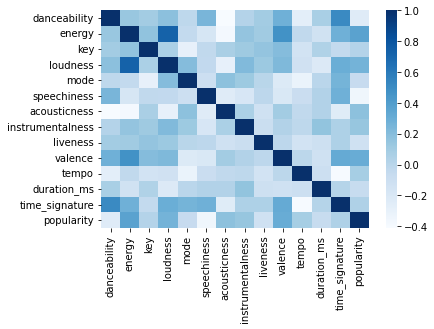

In [ ]:
#feature correlation with popularity of song
corr = final_df.corr()
sns.heatmap(corr, cmap="Blues")
print("Correlation with popularity score:")
corr['top_popularity_correlations'] = np.abs(corr['popularity'])
corr2 = corr.sort_values('top_popularity_correlations', ascending = False)
pd.DataFrame(corr2['top_popularity_correlations'])

Scatterplots of top 6 features correlated with popularity: instrumentalness, loudness, mode, duration_ms, liveness, valence

(70.0, 101.0)

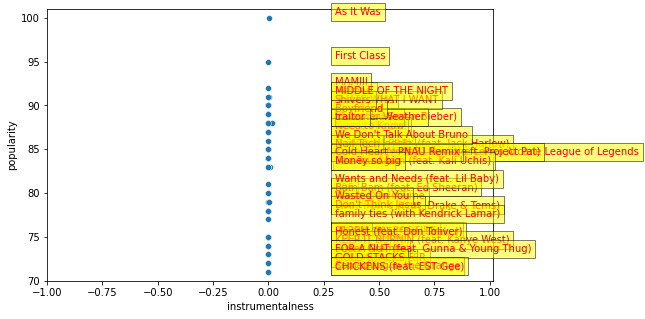

In [ ]:
#instrumentalness
#sns.regplot(data=final_df, x="instrumentalness", y="popularity").set_title('Popularity vs. Instrumentalness')

plt.figure(figsize=(8,5))
sns.scatterplot(data=final_df,x="instrumentalness",y="popularity")
for i in range(final_df.shape[0]):
 plt.text(x=final_df.instrumentalness[i]+0.3,y=final_df.popularity[i]+0.3,s=final_df.track_name[i], fontdict=dict(color='red',size=10),bbox=dict(facecolor='yellow',alpha=0.5))
plt.xlim(final_df.instrumentalness.min()-1,final_df.instrumentalness.max()+1)                #set x limit
plt.ylim(final_df.popularity.min()-1,final_df.popularity.max()+1)              #set y limit 


Text(0.5, 1.0, 'Popularity vs. Loudness')

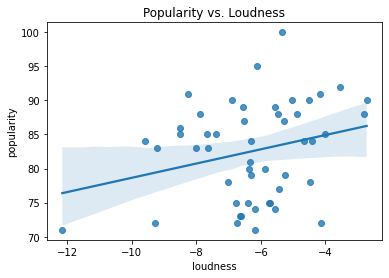

In [ ]:
#loudness
sns.regplot(data=final_df, x="loudness", y="popularity").set_title('Popularity vs. Loudness')

Text(0.5, 1.0, 'Popularity vs. Mode')

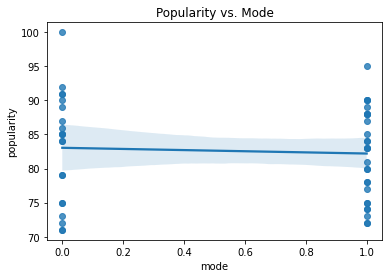

In [ ]:
#mode
sns.regplot(data=final_df, x="mode", y="popularity").set_title('Popularity vs. Mode')

Text(0.5, 1.0, 'Popularity vs. Duration_ms')

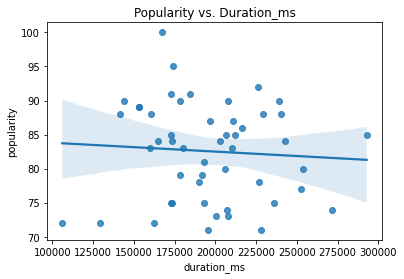

In [ ]:
#duration_ms
sns.regplot(data=final_df, x="duration_ms", y="popularity").set_title('Popularity vs. Duration_ms')

Text(0.5, 1.0, 'Popularity vs. Liveness')

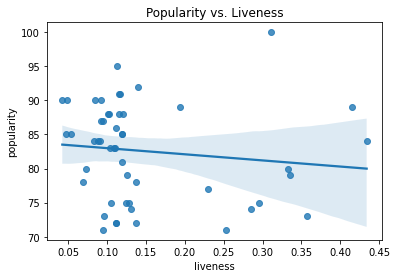

In [ ]:
#liveness
sns.regplot(data=final_df, x="liveness", y="popularity").set_title('Popularity vs. Liveness')

Text(0.5, 1.0, 'Popularity vs. Valence')

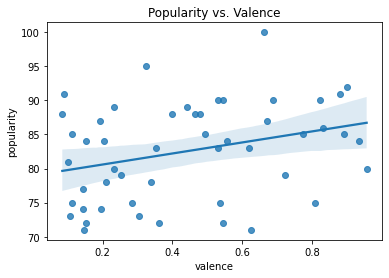

In [ ]:
#valence
sns.regplot(data=final_df, x="valence", y="popularity").set_title('Popularity vs. Valence')

5. Data Cleaning & Preprocessing

In [ ]:
final_df.isna().sum() #no missing data

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
genre               0
album               0
popularity          0
name                0
track_name          0
dtype: int64

In [ ]:
#scale features 
#include popularity in addition to just sound features
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'popularity'] 

scaler = MinMaxScaler()
df_norm = scaler.fit_transform(final_df[features])
df_norm

array([[3.06479860e-01, 8.08095952e-01, 5.45454545e-01, 7.22711361e-01,
        0.00000000e+00, 8.77781164e-02, 4.94796695e-01, 5.70621469e-02,
        6.85903984e-01, 6.62495695e-01, 7.59667344e-01, 3.27697599e-01,
        1.00000000e+00, 1.00000000e+00],
       [9.80735552e-01, 5.56221889e-01, 7.27272727e-01, 6.38166967e-01,
        1.00000000e+00, 2.28893630e-01, 3.64947866e-02, 5.48587571e-04,
        1.80286006e-01, 2.74480542e-01, 2.55926846e-01, 3.63295940e-01,
        1.00000000e+00, 8.27586207e-01],
       [2.06654991e-01, 6.74662669e-01, 9.09090909e-02, 8.14363000e-01,
        1.00000000e+00, 9.54282231e-01, 4.54264625e-01, 0.00000000e+00,
        6.69050051e-02, 2.91700149e-01, 7.82418906e-02, 4.48715888e-01,
        1.00000000e+00, 2.41379310e-01],
       [9.42206655e-01, 6.97151424e-01, 7.27272727e-01, 6.79219264e-01,
        1.00000000e+00, 8.47607437e-01, 8.70151170e-02, 0.00000000e+00,
        2.18590398e-01, 2.28561589e-01, 3.91352450e-01, 3.57858421e-01,
        1.000

In [ ]:
#indices & track name
indices = pd.Series(final_df.index, index=final_df['track_name']).drop_duplicates()
indices

track_name
As It Was                                                       0
First Class                                                     1
WAIT FOR U (feat. Drake & Tems)                                 2
PUFFIN ON ZOOTIEZ                                               3
Heat Waves                                                      4
I'M ON ONE (feat. Drake)                                        5
About Damn Time                                                 6
712PM                                                           7
I'M DAT N****                                                   8
INDUSTRY BABY (feat. Jack Harlow)                               9
No Role Modelz                                                 10
STAY (with Justin Bieber)                                      11
KEEP IT BURNIN (feat. Kanye West)                              12
good 4 u                                                       13
Woman                                                          14

6. Build Content-Based Recommender

In [ ]:
#find cosine similarity
cos_sim = cosine_similarity(df_norm)
cos_sim

array([[1.        , 0.76739383, 0.6466187 , ..., 0.66031994, 0.79919225,
        0.76329734],
       [0.76739383, 1.        , 0.78460955, ..., 0.85232326, 0.78389007,
        0.93507829],
       [0.6466187 , 0.78460955, 1.        , ..., 0.93510978, 0.6696159 ,
        0.86369325],
       ...,
       [0.66031994, 0.85232326, 0.93510978, ..., 1.        , 0.7018359 ,
        0.92320495],
       [0.79919225, 0.78389007, 0.6696159 , ..., 0.7018359 , 1.        ,
        0.73907747],
       [0.76329734, 0.93507829, 0.86369325, ..., 0.92320495, 0.73907747,
        1.        ]])

In [ ]:
#get recommendation
def CB_rec(trackname, topmost_recs):
    index = indices[trackname]
    cos_score = list(enumerate(cos_sim[indices[trackname]])) #changed cos_sim to final_df
    sim_score = sorted(cos_score,key = lambda x:x[1],reverse = True)
    
    #Get top 'topmost_recs' songs
    sim_score2 = sim_score[1:topmost_recs+1]
    topsongs_i = [i[0] for i in sim_score2]
    top_songs = final_df['track_name'].iloc[topsongs_i]
    top_artists = final_df['name'].iloc[topsongs_i]
    return top_songs

In [ ]:
CB_rec('good 4 u', 3)

24                            Dark Red
44                             Shivers
37    See You Again (feat. Kali Uchis)
Name: track_name, dtype: object

7. Model Evaluation
- Determine model baesline --> with vs without recommender
- baseline: next track (in order) that plays next
- recommended results: next song recommended

Calculate the recall.


In [ ]:
#song that will play next in line 
baseline_df = final_df
#assuming on repeat
track_list = list(final_df['track_name'])
next_track_list = track_list[1:]+track_list[0:1]

len(track_list), len(next_track_list)
baseline_df['next_track'] = next_track_list
baseline_df

#song that will play next based on what recommender suggests
rec_list = []
for i in range(len(track_list)):
    recs = CB_rec(track_list[i], 1)
    rec_list.append(''.join(list(recs)))
rec_list
baseline_df['recommended_track'] = rec_list
baseline_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,analysis_url,duration_ms,time_signature,genre,album,popularity,name,track_name,next_track,recommended_track
0,0.520,0.731,6,-5.338,0,0.0557,0.342000,0.001010,0.3110,0.6620,...,https://api.spotify.com/v1/audio-analysis/4LRP...,167303,4,[pop],As It Was,100,Harry Styles,As It Was,First Class,Woman
1,0.905,0.563,8,-6.135,1,0.1020,0.025400,0.000010,0.1130,0.3240,...,https://api.spotify.com/v1/audio-analysis/1rDQ...,173948,4,"[deep underground hip hop, kentucky hip hop, rap]",First Class,95,Jack Harlow,First Class,WAIT FOR U (feat. Drake & Tems),Monëy so big
2,0.463,0.642,1,-4.474,1,0.3400,0.314000,0.000000,0.0686,0.3390,...,https://api.spotify.com/v1/audio-analysis/59nO...,189893,4,"[atl hip hop, pop rap, rap, southern hip hop, ...",I NEVER LIKED YOU,78,Future,WAIT FOR U (feat. Drake & Tems),PUFFIN ON ZOOTIEZ,Wants and Needs (feat. Lil Baby)
3,0.883,0.657,8,-5.748,1,0.3050,0.060300,0.000000,0.1280,0.2840,...,https://api.spotify.com/v1/audio-analysis/1qMM...,172933,4,"[atl hip hop, pop rap, rap, southern hip hop, ...",I NEVER LIKED YOU,75,Future,PUFFIN ON ZOOTIEZ,Heat Waves,family ties (with Kendrick Lamar)
4,0.761,0.525,11,-6.900,1,0.0944,0.440000,0.000007,0.0921,0.5310,...,https://api.spotify.com/v1/audio-analysis/02MW...,238805,4,"[gauze pop, indietronica, shiver pop]",Dreamland (+ Bonus Levels),90,Glass Animals,Heat Waves,I'M ON ONE (feat. Drake),I Love You So
5,0.773,0.707,11,-5.710,1,0.0568,0.010300,0.000010,0.2960,0.1130,...,https://api.spotify.com/v1/audio-analysis/6wyh...,236187,4,"[atl hip hop, pop rap, rap, southern hip hop, ...",I NEVER LIKED YOU,75,Future,I'M ON ONE (feat. Drake),About Damn Time,Super Gremlin
6,0.836,0.743,10,-6.305,0,0.0656,0.099500,0.000000,0.3350,0.7220,...,https://api.spotify.com/v1/audio-analysis/1Pck...,191822,4,"[dance pop, escape room, minnesota hip hop, po...",About Damn Time,79,Lizzo,About Damn Time,712PM,CHICKENS (feat. EST Gee)
7,0.711,0.686,5,-6.409,0,0.2710,0.035500,0.000000,0.1240,0.5360,...,https://api.spotify.com/v1/audio-analysis/3FSw...,173187,4,"[atl hip hop, pop rap, rap, southern hip hop, ...",I NEVER LIKED YOU,75,Future,712PM,I'M DAT N****,GOLD STACKS
8,0.911,0.573,2,-5.573,1,0.1630,0.011200,0.000058,0.1310,0.1450,...,https://api.spotify.com/v1/audio-analysis/0AAV...,271840,4,"[atl hip hop, pop rap, rap, southern hip hop, ...",I NEVER LIKED YOU,74,Future,I'M DAT N****,INDUSTRY BABY (feat. Jack Harlow),family ties (with Kendrick Lamar)
9,0.741,0.691,10,-7.395,0,0.0672,0.022100,0.000000,0.0476,0.8920,...,https://api.spotify.com/v1/audio-analysis/5Z9K...,212353,4,"[lgbtq+ hip hop, pop]",MONTERO,85,Lil Nas X,INDUSTRY BABY (feat. Jack Harlow),No Role Modelz,Honest (feat. Don Toliver)


In [ ]:
#next_track
next_track_sf = []
for i in range(len(next_track_list)):
    r = baseline_df.loc[baseline_df['track_name'] == next_track_list[i]][features].values.flatten().tolist()
    next_track_sf.append(r)

#recommended_track
rec_track_list = list(baseline_df['recommended_track'])
recommended_track_sf = []
for i in range(len(rec_track_list)):
    r2 = baseline_df.loc[baseline_df['track_name'] == rec_track_list[i]][features].values.flatten().tolist()
    recommended_track_sf.append(r2)

#current_track
curr_track_list = list(baseline_df['track_name'])
current_track_sf = []
for i in range(len(curr_track_list)):
    r3 = baseline_df.loc[baseline_df['track_name'] == curr_track_list[i]][features].values.flatten().tolist()
    current_track_sf.append(r3)


In [ ]:
#recall = # of relevant recommendations / # of all possible relevant items
#precision = # of relevant recommendations / # of items recommended
import difflib
#similarity between track_name & next_track vs track_name & recommneded_track?

#track_name & next_track
curr_next = []
curr_rec = []
for i in range(len(current_track_sf)):
    sim_cn=difflib.SequenceMatcher(None,current_track_sf[i],next_track_sf[i]).ratio()
    sim_cr=difflib.SequenceMatcher(None,current_track_sf[i],recommended_track_sf[i]).ratio()

    #sim_cn = cosine_similarity(np.asarray(current_track_sf)[i].reshape(1, -1), np.asarray(next_track_sf)[i].reshape(1, -1))
    #sim_cr = cosine_similarity(np.asarray(current_track_sf)[0].reshape(1, -1), np.asarray(recommended_track_sf)[0].reshape(1, -1))
    curr_next.append(sim_cn)
    curr_rec.append(sim_cr)

#curr_next, curr_rec
rec_better = []
for i in range(len(curr_next)):
    rec_bet = (curr_next[i] <= curr_rec[i])
    rec_better.append(rec_bet)
#rec_better

In [ ]:
#precision = # of relevant recommendations / # of items recommended
precision = rec_better.count(True) / len(rec_better)
precision

0.92

8. Test on other playlists: Take 3 very different playlists, combine them, and run recommender on a song to see if it preicts something in the same playlist
- Jazz Study playlist: https://open.spotify.com/playlist/7jHEx7oHxN4B7PKCLapcq9?si=bf6e8c0e17404cf4
- Mandarin playlist: https://open.spotify.com/playlist/340MRzAs8Ro5dgGtHA8hUZ?si=44ee0e93c0424c86
- Meditation playlist: https://open.spotify.com/playlist/3ksy3Zso4vdt4JIzTYvpF9?si=ef7b395459424ec0

In [ ]:
playlist_link1 = "https://open.spotify.com/playlist/7jHEx7oHxN4B7PKCLapcq9?si=bf6e8c0e17404cf4"
playlist_URI1 = playlist_link1.split("/")[-1].split("?")[0]
track_uris1 = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI1)["items"]]

playlist_link2 = "https://open.spotify.com/playlist/340MRzAs8Ro5dgGtHA8hUZ?si=44ee0e93c0424c86"
playlist_URI2 = playlist_link2.split("/")[-1].split("?")[0]
track_uris2 = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI2)["items"]]

playlist_link3 = "https://open.spotify.com/playlist/3ksy3Zso4vdt4JIzTYvpF9?si=ef7b395459424ec0"
playlist_URI3 = playlist_link3.split("/")[-1].split("?")[0]
track_uris3 = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI3)["items"]]

In [ ]:
#Playlist1
print('Jazz Study playlist:')
audio_features1 = []
for i in range(len(track_uris1)):
    audio_features1.append(sp.audio_features(track_uris1[i]))
audio_features1[0]

track_names1 = []
for k in sp.playlist_tracks(playlist_URI1)["items"]:
    track_names1.append(k["track"]["name"])
print(track_names1)

#Playlist2
print('Mandarin playlist:')
audio_features2 = []
for i in range(len(track_uris2)):
    audio_features2.append(sp.audio_features(track_uris2[i]))
audio_features2[0]

track_names2 = []
for k in sp.playlist_tracks(playlist_URI2)["items"]:
    track_names2.append(k["track"]["name"])
print(track_names2)

#Playlist3
print("Meditation playlist:")
audio_features3 = []
for i in range(len(track_uris3)):
    audio_features3.append(sp.audio_features(track_uris3[i]))
audio_features3[0]

track_names3 = []
for k in sp.playlist_tracks(playlist_URI3)["items"]:
    track_names3.append(k["track"]["name"])
print(track_names3)

Jazz Study playlist:
['New York Nights', 'Near You', 'Misty', 'All I See is Us', 'Saga of Harrison Crabfeathers', 'Halfway', 'The Sweetest Nighlife', "I'd Rather Be Alone", 'Just The Way You Are', 'Got That Feeling', 'Cry Me A River', 'Rosalinde', 'Melody of Summer', 'No Other Woman', 'Kissing in the Streets', 'Autumn Leaves', 'When I Fall In Love', 'As She Rises', 'Clear Bridge', 'The Last Time', 'I Have A Dream', 'Girl From Ipanema', 'Budapest Nights', 'Swing Low Sweet Chariot', 'My Heart Is For You', 'Forgiving is Forgetting', "Isn't She Lovely", 'Stay', "It's Gonna Be a Good Day", 'Walk On By', 'Chiquitita', 'My Funny Valentine', 'Summertime', 'My Simple Thing', 'The Winner Takes It All', 'What A Wonderful World', 'Every Breath You Take', 'Imagine', 'Fly Me To The Moon', 'Over The Rainbow', 'Inner City Drive', 'Unforgetable', 'On Your Lips', 'Under A Smiling Moon', 'Fancy Fancy', 'Smile', 'In Thoughtful', 'Home', 'I´ll Never Smile Again', 'Abisko', 'Peace', "I Can't Get Started", '

In [ ]:
len(track_names1) + len(track_names2) + len(track_names3)

256

In [ ]:
#Playlist1
dfs = []

for x in audio_features1:
    df = pd.DataFrame(x)
    dfs.append(df)

final_df1 = pd.concat(dfs, ignore_index=True)

#add URI, track_name, main artist, name, popularity, genre, and album to final_df

URIs = []
track_names = []
main_artist = []
name = []
popularity = []
genre = []
album = []

for k in sp.playlist_tracks(playlist_URI1)["items"]:
    URIs.append(k["track"]["uri"])
    track_names.append(k["track"]["name"])
    main_artist.append(k["track"]["artists"][0]["uri"])
    name.append(k["track"]["artists"][0]["name"]) #arist URL
    album.append(k["track"]["album"]["name"])
    popularity.append(k["track"]["popularity"])

#artist_info & genre
artist_info = []
for r in range(len(main_artist)):
    artist_info.append(sp.artist(main_artist[r]))

for y in artist_info:
    genre.append(y["genres"])

#add genre, album, popularity, name, main_artist, track_names, and URIs to final_df for more context

final_df1['genre'] = genre
final_df1['album'] = album
final_df1['popularity'] = popularity
final_df1['name'] = name
final_df1['track_name'] = track_names
final_df1.to_csv('final_df1.csv')
final_df1

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,genre,album,popularity,name,track_name
0,0.358,0.04820,11,-18.887,1,0.0452,0.994,0.941,0.1090,0.3660,...,spotify:track:1e5Xxhz3Ij8TLCNuhB2IEL,https://api.spotify.com/v1/tracks/1e5Xxhz3Ij8T...,https://api.spotify.com/v1/audio-analysis/1e5X...,170496,5,[],Maude De Geyndt,37,Maude De Geyndt,New York Nights
1,0.391,0.03430,11,-19.342,1,0.0480,0.987,0.924,0.0943,0.1800,...,spotify:track:2RF7VdZ8LSDU80BS1gnf7I,https://api.spotify.com/v1/tracks/2RF7VdZ8LSDU...,https://api.spotify.com/v1/audio-analysis/2RF7...,184289,4,[],Forgiving is Forgetting,31,Hip Jazz Collective,Near You
2,0.429,0.05100,8,-15.024,1,0.0605,0.995,0.961,0.1160,0.1780,...,spotify:track:06HQejVsTz9NqkSmxsVCCM,https://api.spotify.com/v1/tracks/06HQejVsTz9N...,https://api.spotify.com/v1/audio-analysis/06HQ...,299181,4,"[christmas instrumental, pianissimo]",Session 1,38,Ahron Kupner,Misty
3,0.460,0.14100,9,-14.994,1,0.0314,0.854,0.885,0.1100,0.1470,...,spotify:track:2wx4FLHxxKP6wJvgp3Cceu,https://api.spotify.com/v1/tracks/2wx4FLHxxKP6...,https://api.spotify.com/v1/audio-analysis/2wx4...,278071,3,[],Kissing in the Streets,37,Sassy Players,All I See is Us
4,0.684,0.27400,11,-15.921,0,0.0339,0.822,0.909,0.1120,0.1800,...,spotify:track:1D93vTG8Uio5cpf5YRF4Do,https://api.spotify.com/v1/tracks/1D93vTG8Uio5...,https://api.spotify.com/v1/audio-analysis/1D93...,266669,3,[christmas instrumental],Jazz Standards,35,Milos Foreman,Saga of Harrison Crabfeathers
5,0.735,0.16900,11,-17.437,1,0.0375,0.859,0.938,0.1140,0.0910,...,spotify:track:08wGol6j6NY9WlPXaD20Sb,https://api.spotify.com/v1/tracks/08wGol6j6NY9...,https://api.spotify.com/v1/audio-analysis/08wG...,228123,4,[],Halfway,36,Ilya Mann,Halfway
6,0.425,0.13600,11,-17.382,1,0.0293,0.914,0.921,0.1270,0.2380,...,spotify:track:0Vh8hPIxImlwXBj7KOJMhW,https://api.spotify.com/v1/tracks/0Vh8hPIxImlw...,https://api.spotify.com/v1/audio-analysis/0Vh8...,176272,3,[],Stop Look Desire,40,Ellie & The Bunch,The Sweetest Nighlife
7,0.404,0.20100,4,-15.549,1,0.0383,0.946,0.906,0.1060,0.2720,...,spotify:track:3aMPhbRGGTBCwWxVoHLOHu,https://api.spotify.com/v1/tracks/3aMPhbRGGTBC...,https://api.spotify.com/v1/audio-analysis/3aMP...,247835,3,[background music],Someone Who Cares,0,Franz Gordon,I'd Rather Be Alone
8,0.573,0.06430,7,-19.774,1,0.0728,0.996,0.943,0.0984,0.2080,...,spotify:track:0BteZ0GPP4VO3M1k5NYDVE,https://api.spotify.com/v1/tracks/0BteZ0GPP4VO...,https://api.spotify.com/v1/audio-analysis/0Bte...,236026,4,"[calming instrumental, christmas instrumental,...",Classics,36,Brandon Mills,Just The Way You Are
9,0.482,0.18900,10,-15.645,1,0.0404,0.794,0.796,0.1260,0.2130,...,spotify:track:2VY6cGSr6iDouF55iOS6Ok,https://api.spotify.com/v1/tracks/2VY6cGSr6iDo...,https://api.spotify.com/v1/audio-analysis/2VY6...,359937,4,"[compositional ambient, focus, neo-classical]",A Scandinavian Thing,0,Peter Sandberg,Got That Feeling


In [ ]:
#Playlist2
dfs = []

for x in audio_features2:
    df = pd.DataFrame(x)
    dfs.append(df)

final_df2 = pd.concat(dfs, ignore_index=True)

#add URI, track_name, main artist, name, popularity, genre, and album to final_df

URIs = []
track_names = []
main_artist = []
name = []
popularity = []
genre = []
album = []

for k in sp.playlist_tracks(playlist_URI2)["items"]:
    URIs.append(k["track"]["uri"])
    track_names.append(k["track"]["name"])
    main_artist.append(k["track"]["artists"][0]["uri"])
    name.append(k["track"]["artists"][0]["name"]) #arist URL
    album.append(k["track"]["album"]["name"])
    popularity.append(k["track"]["popularity"])

#artist_info & genre
artist_info = []
for r in range(len(main_artist)):
    artist_info.append(sp.artist(main_artist[r]))

for y in artist_info:
    genre.append(y["genres"])

#add genre, album, popularity, name, main_artist, track_names, and URIs to final_df for more context

final_df2['genre'] = genre
final_df2['album'] = album
final_df2['popularity'] = popularity
final_df2['name'] = name
final_df2['track_name'] = track_names
final_df2.to_csv('final_df2.csv')
final_df2

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,genre,album,popularity,name,track_name
0,0.496,0.515,9,-9.520,1,0.0352,0.7010,0.000168,0.1550,0.263,...,spotify:track:2IAumRplFr0Ns09kKgt2je,https://api.spotify.com/v1/tracks/2IAumRplFr0N...,https://api.spotify.com/v1/audio-analysis/2IAu...,321040,4,[mandopop],終於了解自由,54,Eric Chou,怎麼了
1,0.559,0.505,6,-7.012,1,0.0359,0.6700,0.000000,0.0932,0.221,...,spotify:track:09NpNi1RKNgCAvdRRugc33,https://api.spotify.com/v1/tracks/09NpNi1RKNgC...,https://api.spotify.com/v1/audio-analysis/09Np...,349133,4,"[mandopop, taiwan pop]",黏黏,26,Cyndi Wang,下一頁的我
2,0.658,0.240,11,-8.308,1,0.0311,0.9280,0.000000,0.0747,0.238,...,spotify:track:5uj0henHh9OgeOViRZGPiG,https://api.spotify.com/v1/tracks/5uj0henHh9Og...,https://api.spotify.com/v1/audio-analysis/5uj0...,183867,4,"[mandopop, taiwan pop]",好難得,36,Della,好難得
3,0.512,0.350,10,-11.843,1,0.0311,0.4780,0.000001,0.0855,0.343,...,spotify:track:56wVfJKtnwlSZtC4NVgIrf,https://api.spotify.com/v1/tracks/56wVfJKtnwlS...,https://api.spotify.com/v1/audio-analysis/56wV...,222333,4,"[c-pop, mandopop, taiwan pop, zhongguo feng]",說好不哭,59,Jay Chou,說好不哭
4,0.591,0.595,11,-9.984,0,0.0653,0.6410,0.000000,0.1610,0.611,...,spotify:track:3oTmOv9KjIcOfRTfGH5c62,https://api.spotify.com/v1/tracks/3oTmOv9KjIcO...,https://api.spotify.com/v1/audio-analysis/3oTm...,239286,4,"[mandopop, taiwan pop]",《狼殿下》影視原聲帶,44,Jolin Tsai,我是誰 (電視劇《狼殿下》主題曲)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.767,0.625,11,-7.430,0,0.1800,0.0264,0.000002,0.1220,0.580,...,spotify:track:0cONHWTIfgEpAuVwbbwGgc,https://api.spotify.com/v1/tracks/0cONHWTIfgEp...,https://api.spotify.com/v1/audio-analysis/0cON...,182344,4,"[mandopop, taiwan pop]",Ugly Beauty,47,Jolin Tsai,怪美的
96,0.824,0.877,8,-4.757,0,0.0447,0.0196,0.000311,0.1400,0.316,...,spotify:track:18ImQnN3yZxL6vDQiOvata,https://api.spotify.com/v1/tracks/18ImQnN3yZxL...,https://api.spotify.com/v1/audio-analysis/18Im...,193360,4,"[mandopop, taiwan pop]",呸,44,Jolin Tsai,Play我呸
97,0.550,0.849,2,-3.961,1,0.0565,0.5100,0.000000,0.0436,0.795,...,spotify:track:0QxlXlQZD78tjivjAtQglz,https://api.spotify.com/v1/tracks/0QxlXlQZD78t...,https://api.spotify.com/v1/audio-analysis/0Qxl...,268453,4,"[c-pop, malaysian mandopop, mandopop]",現在開始我愛你[戀愛的力量][下集]新歌+精選,20,Fish Leong,沒有如果
98,0.426,0.487,2,-5.276,1,0.0361,0.7850,0.000000,0.2590,0.280,...,spotify:track:5kZDxLcbqglZ2yYXg4Mkjc,https://api.spotify.com/v1/tracks/5kZDxLcbqglZ...,https://api.spotify.com/v1/audio-analysis/5kZD...,244470,4,"[mandopop, singaporean mandopop, singaporean pop]",學不會,58,JJ Lin,那些你很冒險的夢


In [ ]:
#Playlist3
dfs = []

for x in audio_features3:
    df = pd.DataFrame(x)
    dfs.append(df)

final_df3 = pd.concat(dfs, ignore_index=True)

#add URI, track_name, main artist, name, popularity, genre, and album to final_df

URIs = []
track_names = []
main_artist = []
name = []
popularity = []
genre = []
album = []

for k in sp.playlist_tracks(playlist_URI3)["items"]:
    URIs.append(k["track"]["uri"])
    track_names.append(k["track"]["name"])
    main_artist.append(k["track"]["artists"][0]["uri"])
    name.append(k["track"]["artists"][0]["name"]) #arist URL
    album.append(k["track"]["album"]["name"])
    popularity.append(k["track"]["popularity"])

#artist_info & genre
artist_info = []
for r in range(len(main_artist)):
    artist_info.append(sp.artist(main_artist[r]))

for y in artist_info:
    genre.append(y["genres"])

#add genre, album, popularity, name, main_artist, track_names, and URIs to final_df for more context

final_df3['genre'] = genre
final_df3['album'] = album
final_df3['popularity'] = popularity
final_df3['name'] = name
final_df3['track_name'] = track_names
final_df3.to_csv('final_df3.csv')
final_df3

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,genre,album,popularity,name,track_name
0,0.1430,0.15500,3,-21.899,1,0.0413,0.988,0.74000,0.1090,0.0389,...,spotify:track:1aeKotbZ2wBYuOspDawtwo,https://api.spotify.com/v1/tracks/1aeKotbZ2wBY...,https://api.spotify.com/v1/audio-analysis/1aeK...,137509,4,[background music],Mandala,60,Lhokanda,Mandala
1,0.2020,0.11200,0,-20.236,1,0.0422,0.991,0.84000,0.0769,0.0368,...,spotify:track:2sqE9z7rJlzV5ZgieeUatU,https://api.spotify.com/v1/tracks/2sqE9z7rJlzV...,https://api.spotify.com/v1/audio-analysis/2sqE...,144091,4,[background music],Space,56,Matter and Energy,Orbital
2,0.0723,0.10100,3,-22.677,1,0.0498,0.783,0.89500,0.1020,0.0319,...,spotify:track:2Qmg0oyUxivJVhVxbXEZcO,https://api.spotify.com/v1/tracks/2Qmg0oyUxivJ...,https://api.spotify.com/v1/audio-analysis/2Qmg...,200946,3,[background music],Waves,56,Opus Monik,Waves
3,0.1370,0.03080,5,-30.158,1,0.0411,0.936,0.95300,0.1260,0.0389,...,spotify:track:7wKteYGjLxGYGYw45SFCS0,https://api.spotify.com/v1/tracks/7wKteYGjLxGY...,https://api.spotify.com/v1/audio-analysis/7wKt...,123799,4,[],दुनिया के सपने,57,Raku-Nu,दुनिया के सपने
4,0.2020,0.00172,2,-35.595,1,0.0408,0.952,0.85300,0.1110,0.0378,...,spotify:track:6xhwbnVSG3DeLM6oZau2Mr,https://api.spotify.com/v1/tracks/6xhwbnVSG3De...,https://api.spotify.com/v1/audio-analysis/6xhw...,192000,3,[background music],The Minimalist,54,Benjamin Martins,Hypnosis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.3060,0.33900,8,-13.598,0,0.0418,0.397,0.00113,0.1040,0.0307,...,spotify:track:0r1Lskg885JtBYN2zeC6wM,https://api.spotify.com/v1/tracks/0r1Lskg885Jt...,https://api.spotify.com/v1/audio-analysis/0r1L...,114639,3,[],Dreams,54,Silkroad,Dreams
96,0.1440,0.11600,11,-26.927,0,0.0641,0.623,0.91300,0.0918,0.0444,...,spotify:track:5M2vSYhLSDww1n3x2zB1qN,https://api.spotify.com/v1/tracks/5M2vSYhLSDww...,https://api.spotify.com/v1/audio-analysis/5M2v...,176432,3,[background music],Winds of Haryana,45,Muni Yogi,Winds of Haryana
97,0.1450,0.04100,5,-25.220,1,0.0348,0.982,0.86800,0.2630,0.0403,...,spotify:track:1OMmObhWmRz0dpiARmgSL7,https://api.spotify.com/v1/tracks/1OMmObhWmRz0...,https://api.spotify.com/v1/audio-analysis/1OMm...,204189,4,[],Keep Climbing,48,Nordic Winds,Keep Climbing
98,0.3800,0.01000,9,-29.684,1,0.0375,0.996,0.84200,0.1080,0.1630,...,spotify:track:6ppu6cIKlNB6b2XPbFlKfV,https://api.spotify.com/v1/tracks/6ppu6cIKlNB6...,https://api.spotify.com/v1/audio-analysis/6ppu...,112800,4,[],Follow Along,47,Riverside Underground,Follow Along


In [ ]:
#Combine all playlists into 1 dataframe
concat_df1 = pd.concat([final_df1, final_df2])
concat_df2 = pd.concat([concat_df1,final_df3])
concat_df2


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,genre,album,popularity,name,track_name
0,0.358,0.04820,11,-18.887,1,0.0452,0.994,0.94100,0.1090,0.3660,...,spotify:track:1e5Xxhz3Ij8TLCNuhB2IEL,https://api.spotify.com/v1/tracks/1e5Xxhz3Ij8T...,https://api.spotify.com/v1/audio-analysis/1e5X...,170496,5,[],Maude De Geyndt,37,Maude De Geyndt,New York Nights
1,0.391,0.03430,11,-19.342,1,0.0480,0.987,0.92400,0.0943,0.1800,...,spotify:track:2RF7VdZ8LSDU80BS1gnf7I,https://api.spotify.com/v1/tracks/2RF7VdZ8LSDU...,https://api.spotify.com/v1/audio-analysis/2RF7...,184289,4,[],Forgiving is Forgetting,31,Hip Jazz Collective,Near You
2,0.429,0.05100,8,-15.024,1,0.0605,0.995,0.96100,0.1160,0.1780,...,spotify:track:06HQejVsTz9NqkSmxsVCCM,https://api.spotify.com/v1/tracks/06HQejVsTz9N...,https://api.spotify.com/v1/audio-analysis/06HQ...,299181,4,"[christmas instrumental, pianissimo]",Session 1,38,Ahron Kupner,Misty
3,0.460,0.14100,9,-14.994,1,0.0314,0.854,0.88500,0.1100,0.1470,...,spotify:track:2wx4FLHxxKP6wJvgp3Cceu,https://api.spotify.com/v1/tracks/2wx4FLHxxKP6...,https://api.spotify.com/v1/audio-analysis/2wx4...,278071,3,[],Kissing in the Streets,37,Sassy Players,All I See is Us
4,0.684,0.27400,11,-15.921,0,0.0339,0.822,0.90900,0.1120,0.1800,...,spotify:track:1D93vTG8Uio5cpf5YRF4Do,https://api.spotify.com/v1/tracks/1D93vTG8Uio5...,https://api.spotify.com/v1/audio-analysis/1D93...,266669,3,[christmas instrumental],Jazz Standards,35,Milos Foreman,Saga of Harrison Crabfeathers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.306,0.33900,8,-13.598,0,0.0418,0.397,0.00113,0.1040,0.0307,...,spotify:track:0r1Lskg885JtBYN2zeC6wM,https://api.spotify.com/v1/tracks/0r1Lskg885Jt...,https://api.spotify.com/v1/audio-analysis/0r1L...,114639,3,[],Dreams,54,Silkroad,Dreams
96,0.144,0.11600,11,-26.927,0,0.0641,0.623,0.91300,0.0918,0.0444,...,spotify:track:5M2vSYhLSDww1n3x2zB1qN,https://api.spotify.com/v1/tracks/5M2vSYhLSDww...,https://api.spotify.com/v1/audio-analysis/5M2v...,176432,3,[background music],Winds of Haryana,45,Muni Yogi,Winds of Haryana
97,0.145,0.04100,5,-25.220,1,0.0348,0.982,0.86800,0.2630,0.0403,...,spotify:track:1OMmObhWmRz0dpiARmgSL7,https://api.spotify.com/v1/tracks/1OMmObhWmRz0...,https://api.spotify.com/v1/audio-analysis/1OMm...,204189,4,[],Keep Climbing,48,Nordic Winds,Keep Climbing
98,0.380,0.01000,9,-29.684,1,0.0375,0.996,0.84200,0.1080,0.1630,...,spotify:track:6ppu6cIKlNB6b2XPbFlKfV,https://api.spotify.com/v1/tracks/6ppu6cIKlNB6...,https://api.spotify.com/v1/audio-analysis/6ppu...,112800,4,[],Follow Along,47,Riverside Underground,Follow Along


In [ ]:
#scale features 
#include popularity in addition to just sound features
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'popularity'] 

scaler = MinMaxScaler()
df_norm2 = scaler.fit_transform(concat_df2[features])
df_norm2

array([[0.3873258 , 0.05345987, 1.        , ..., 0.27907698, 1.        ,
        0.60655738],
       [0.4307126 , 0.03758523, 1.        , ..., 0.32103313, 0.75      ,
        0.50819672],
       [0.48067315, 0.05665764, 0.72727273, ..., 0.67051663, 0.75      ,
        0.62295082],
       ...,
       [0.10728372, 0.04523703, 0.45454545, ..., 0.38156582, 0.75      ,
        0.78688525],
       [0.41625033, 0.00983314, 0.81818182, ..., 0.10357477, 0.75      ,
        0.7704918 ],
       [0.23744412, 0.00496797, 0.        , ..., 0.37369049, 0.75      ,
        0.86885246]])

In [ ]:
#indices & track name
indices2 = pd.Series(concat_df2.index, index=concat_df2['track_name'])
indices2

track_name
New York Nights                   0
Near You                          1
Misty                             2
All I See is Us                   3
Saga of Harrison Crabfeathers     4
                                 ..
Dreams                           95
Winds of Haryana                 96
Keep Climbing                    97
Follow Along                     98
Palm Trees                       99
Length: 256, dtype: int64

In [ ]:
#get cos_sim
cos_sim2 = cosine_similarity(df_norm2)
cos_sim2

array([[1.        , 0.98982837, 0.96826476, ..., 0.94077479, 0.97650449,
        0.87275944],
       [0.98982837, 1.        , 0.97924264, ..., 0.94301692, 0.97798543,
        0.86302496],
       [0.96826476, 0.97924264, 1.        , ..., 0.95725618, 0.95129819,
        0.90123776],
       ...,
       [0.94077479, 0.94301692, 0.95725618, ..., 1.        , 0.95951414,
        0.95941476],
       [0.97650449, 0.97798543, 0.95129819, ..., 0.95951414, 1.        ,
        0.90987444],
       [0.87275944, 0.86302496, 0.90123776, ..., 0.95941476, 0.90987444,
        1.        ]])

In [ ]:
#get recommendation
def CB_rec(trackname, topmost_recs):
    index = indices2[trackname]
    cos_score = list(enumerate(cos_sim2[indices2[trackname]])) 
    sim_score = sorted(cos_score,key = lambda x:x[1],reverse = True)
    
    #Get top 'topmost_recs' songs
    sim_score2 = sim_score[1:topmost_recs+1]
    topsongs_i = [i[0] for i in sim_score2]
    top_songs = concat_df2['track_name'].iloc[topsongs_i]
    top_artists = concat_df2['name'].iloc[topsongs_i]
    return top_songs

- try something from jazz playlist and see if recommended songs are in the same playlist

In [ ]:
CB_rec('Near You', 10)

37                    Imagine
38         Fly Me To The Moon
36      Every Breath You Take
0             New York Nights
35     What A Wonderful World
46              In Thoughtful
44                Fancy Fancy
25    Forgiving is Forgetting
23    Swing Low Sweet Chariot
50                      Peace
Name: track_name, dtype: object

In [ ]:
final_df1[final_df1['track_name'] == 'Peace']

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,genre,album,popularity,name,track_name
50,0.505,0.15,10,-17.508,1,0.0335,0.972,0.836,0.11,0.169,...,spotify:track:6qxR6arAISIf7Mm2ynH4u1,https://api.spotify.com/v1/tracks/6qxR6arAISIf...,https://api.spotify.com/v1/audio-analysis/6qxR...,193775,4,[],Relaxin' at Camarillo,46,William Carter Band,Peace


- try something from mandarin playlist and see if recommended songs are in the same playlist 

In [ ]:
CB_rec('沒有如果', 10)

40                        如果雨之後
38                           晴天
34    你,好不好? - TVBS連續劇【遺憾拼圖】片尾曲
66         花背後的溫柔 - 電視劇「流星花園」插曲
0                           怎麼了
13                     你不是真正的快樂
33                          髮如雪
37                     給我一個理由忘記
46                       不能說的秘密
52                        背對背擁抱
Name: track_name, dtype: object

In [ ]:
final_df2['track_name'][97]

'沒有如果'

- try something from meditation playlist and see if recommended songs are in the same playlist

In [ ]:
final_df3['track_name'][4]

'Hypnosis'

In [ ]:
CB_rec("Hypnosis", 10)

9                Moonchild
53    Pastorale in C minor
15           Autumn Leaves
41            Unforgetable
31      My Funny Valentine
85           New Awakening
59                    Time
24                 Forward
12        Melody of Summer
18          Piazzale Mauna
Name: track_name, dtype: object

In [ ]:
final_df3[final_df3['track_name'] == 'Piazzale Mauna']
#moonchild
#new awakening
#time
#forward
#melody of summer
#Piazzale Mauna



,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,genre,album,popularity,name,track_name
18,0.173,0.148,7,-21.697,0,0.0367,0.891,0.826,0.197,0.0389,...,spotify:track:0LKKLpXYCrS4cJLoWELHZs,https://api.spotify.com/v1/tracks/0LKKLpXYCrS4...,https://api.spotify.com/v1/audio-analysis/0LKK...,208594,4,[],Piazzale Mauna,45,Il Sognatore,Piazzale Mauna


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=320dce11-358c-40ca-8194-b0feec0651a9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>